In [347]:
# Scientific Computing
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)

import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import randint, uniform
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split #, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression

import pickle as p


In [348]:
# Import census demographic data - arcgis
census = pd.read_csv('census_arcgis_ca.csv', encoding='latin-1')

# Import census demographic data - 2017 ACS
census_acs = pd.read_csv('census_block_demographic.csv', skiprows=1)
slicer = census_acs['GIS Join Match Code'].str[2:]
slicer = slicer.str[0] + slicer.str[2:5] + slicer.str[6:]
census_acs['FIPS'] = slicer.astype('int64')
    
    # Import QGIS combined block group
df = pd.read_csv('census_precinct_min.csv')

#calculate coverage % of each row over the whole census area
df['pct_whole'] = df['area_v']/df['area_p']

#filter out null values - 2 % is arbitrary, negative offset
df_reduc = df[df['pct_whole'] > 0.02]

# df_reduc = df

# Import precinct election results, 2016 all
election = pd.read_csv('all_precinct_results_2016.csv', low_memory=False)

In [349]:
# Working subset
election_tmp = election[['pct16', 'pres_clinton', 'pres_trump', 'ussenate_harris', 'ussenate_sanchez']]
election_tmp = election_tmp.iloc[:24568] # remove precinct summations for now

election_tmp = election # whole for now...

In [350]:
# Merge QGIS with precincts
cen_to_precinct = df_reduc.merge(election_tmp, on="pct16")

In [351]:
cen_to_precinct.columns

Index(['OBJECTID', 'area_c', 'pct16', 'layer', 'area_p', 'area_v', 'pct_whole',
       'pres_clinton', 'pres_trump', 'pres_johnson', 'pres_stein',
       'pres_lariva', 'pres_other', 'ussenate_harris', 'ussenate_sanchez',
       'prop51_yes', 'prop51_no', 'prop52_yes', 'prop52_no', 'prop53_yes',
       'prop53_no', 'prop54_yes', 'prop54_no', 'prop55_yes', 'prop55_no',
       'prop56_yes', 'prop56_no', 'prop57_yes', 'prop57_no', 'prop58_yes',
       'prop58_no', 'prop59_yes', 'prop59_no', 'prop60_yes', 'prop60_no',
       'prop61_yes', 'prop61_no', 'prop62_yes', 'prop62_no', 'prop63_yes',
       'prop63_no', 'prop64_yes', 'prop64_no', 'prop65_yes', 'prop65_no',
       'prop66_yes', 'prop66_no', 'prop67_yes', 'prop67_no',
       'pres_clinton_per', 'pres_trump_per', 'pres_third_per', 'pres_winner',
       'pres_margin', 'votedensity', 'prop51_yes_per', 'prop51_no_per',
       'prop52_yes_per', 'prop52_no_per', 'prop53_yes_per', 'prop53_no_per',
       'prop54_yes_per', 'prop54_no_per', '

In [352]:
# Take slice only for now; this is duplicable
# Apply pct_whole scaling for each slice in census block group
# This creates new columns scaled by precinct coverage of the census block group.

manip = cen_to_precinct.copy()
manip[['clinton', 'trump', 'harris', 'sanchez', 'prop58_yes', 'prop58_no']] =\
cen_to_precinct[['pres_clinton', 'pres_trump', 
                 'ussenate_harris', 'ussenate_sanchez', 'prop58_yes', 'prop58_no']].multiply(cen_to_precinct['pct_whole'], axis="index")


In [353]:
# GROUPBY census block group and combine
test = manip.groupby(['OBJECTID'])[['clinton', 'trump', 'harris', 'sanchez', 'prop58_yes', 'prop58_no', 'area_v']].sum().reset_index()

In [354]:
#len(test) # 22827
#len(census) # 23194 Throughout the QGIS process this is the census block group count that failed to match

In [355]:
# Now merge with ArcGIS census data.
output = test.merge(census, on=['OBJECTID'])

In [356]:
output.head()

,OBJECTID,clinton,trump,harris,sanchez,prop58_yes,prop58_no,area_v,STATE_FIPS,CNTY_FIPS,...,FAMILIES,AVE_FAM_SZ,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,SQMI,Shape_Leng,Shape_Area,area_c
0,1386.00,193.72,235.21,199.93,172.54,304.40,151.82,504932455.00,6,83,...,220,3.04,410,89,135,186,195.57,1.40,0.05,506526787
1,1389.00,115.30,57.64,109.40,49.62,135.14,45.16,15811599.00,6,83,...,295,3.01,520,78,315,127,9.78,0.26,0.00,25322508
2,1390.00,185.07,198.27,189.70,142.10,273.22,138.12,1056526.00,6,83,...,243,2.81,428,95,246,87,0.57,0.07,0.00,1483883
3,1391.00,400.18,390.19,394.02,268.97,518.70,282.51,1647936.00,6,83,...,488,3.11,937,103,379,455,2.65,0.14,0.00,6858597
4,1392.00,244.36,160.16,238.55,130.84,314.16,124.21,204907500.00,6,83,...,137,3.34,249,45,73,131,82.92,0.94,0.02,214759550


In [357]:
output[['clinton', 'trump', 'harris', 'sanchez']].sum() # slippage count

clinton   8916878.19
trump     4576116.92
harris    7649879.62
sanchez   4843210.37
dtype: float64

In [358]:
#Without 2% filter:
#clinton   8984948.95
#trump     4609906.59
#harris    7708206.55
#sanchez   4879410.88

#Parse results:
#clinton   8916878.19
#trump     4576116.92
#harris    7649879.62
#sanchez   4843210.37

#Actual:
#clinton    8753788
#trump      4483810
#harris     7542753
#sanchez    4701417

# Total slippage:
# (8916878 - 8753788) / 8753788 = 0.0186307916070163
# (4576116 - 4483810) / 4483810 = 0.020586510133123393

In [359]:
# Create new columns

output['pct_hispanic'] = output['HISPANIC']/output['POP2010']
output['pct_sanchez'] = output['sanchez']/(output['harris'] + output['sanchez'])
output['pct_trump'] = output['trump']/(output['trump'] + output['clinton'])
output['pct_trump'] = output['trump']/(output['trump'] + output['clinton'])

#census['sum_pop'] = census['WHITE']+census['BLACK']+census['AMERI_ES']+census['ASIAN']+census['HAWN_PI']+census['OTHER']+census['MULT_RACE'] #+census['HISPANIC']


In [360]:
# Only precincts with enough data

output_sig = output[(output['clinton'] > 10) & (output['trump'] > 10)]

Text(0, 0.5, 'Percent vote for Sanchez')

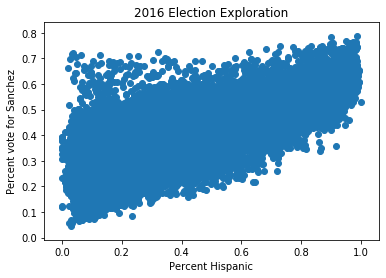

In [361]:
plt.title('2016 Election Exploration')
plt.scatter(output_sig['pct_hispanic'], output_sig['pct_sanchez'])
plt.xlabel('Percent Hispanic')
plt.ylabel('Percent vote for Sanchez')

Text(0, 0.5, 'Percent vote for Prop 58')

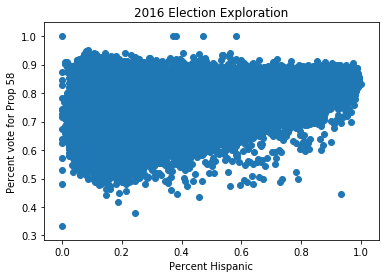

In [362]:
plt.title('2016 Election Exploration')
plt.scatter(output['pct_hispanic'], output['prop58_yes'] / (output['prop58_yes'] + output['prop58_no'])) 
plt.xlabel('Percent Hispanic')
plt.ylabel('Percent vote for Prop 58')

Text(0, 0.5, 'Percent vote for Trump')

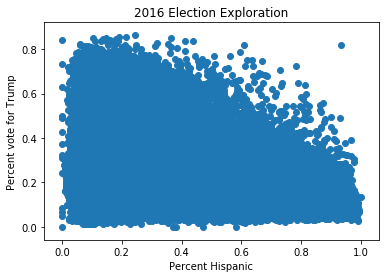

In [363]:
plt.title('2016 Election Exploration')
plt.scatter(output['pct_hispanic'], output['pct_trump'])
plt.xlabel('Percent Hispanic')
plt.ylabel('Percent vote for Trump')

In [364]:
mapping = pd.read_csv('county_code_map.csv')
mapping = mapping.set_index('FIPS_code') 
# hack - change this later to a dict or something


In [365]:
output.columns

Index(['OBJECTID', 'clinton', 'trump', 'harris', 'sanchez', 'prop58_yes',
       'prop58_no', 'area_v', 'STATE_FIPS', 'CNTY_FIPS', 'STCOFIPS', 'TRACT',
       'BLKGRP', 'FIPS', 'POPULATION', 'POP_SQMI', 'POP2010', 'POP10_SQMI',
       'WHITE', 'BLACK', 'AMERI_ES', 'ASIAN', 'HAWN_PI', 'HISPANIC', 'OTHER',
       'MULT_RACE', 'MALES', 'FEMALES', 'AGE_UNDER5', 'AGE_5_9', 'AGE_10_14',
       'AGE_15_19', 'AGE_20_24', 'AGE_25_34', 'AGE_35_44', 'AGE_45_54',
       'AGE_55_64', 'AGE_65_74', 'AGE_75_84', 'AGE_85_UP', 'MED_AGE',
       'MED_AGE_M', 'MED_AGE_F', 'HOUSEHOLDS', 'AVE_HH_SZ', 'HSEHLD_1_M',
       'HSEHLD_1_F', 'MARHH_CHD', 'MARHH_NO_C', 'MHH_CHILD', 'FHH_CHILD',
       'FAMILIES', 'AVE_FAM_SZ', 'HSE_UNITS', 'VACANT', 'OWNER_OCC',
       'RENTER_OCC', 'SQMI', 'Shape_Leng', 'Shape_Area', 'area_c',
       'pct_hispanic', 'pct_sanchez', 'pct_trump'],
      dtype='object')

In [366]:
output_g = output[output['pct_hispanic'] > 0.05]
output_g = output_g.dropna(subset=['pct_sanchez'])

X = np.array(output_g['pct_hispanic']).reshape(-1,1)
y = np.array(output_g['pct_sanchez'])

output_g = output_g.drop(columns=['pct_sanchez'])

In [367]:
F, pval  = f_regression(output_g, y.ravel())
pd.DataFrame(F,index=output_g.columns,columns=['linear correlation']).sort_values('linear correlation',ascending=False)#.head()

C:\Users\Jerod\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\Jerod\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\Jerod\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Jerod\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Jerod\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2

,linear correlation
pct_hispanic,23203.59
AVE_HH_SZ,17041.50
AVE_FAM_SZ,16194.48
HISPANIC,11998.33
OTHER,10723.26
MED_AGE_M,5237.94
MED_AGE,5150.99
MED_AGE_F,4711.47
HSEHLD_1_F,3752.48
harris,3377.14


In [368]:
output_g = output[output['pct_trump'] > 0.05]
output_g = output_g.dropna()

X = np.array(output_g['pct_trump']).reshape(-1,1)
y = np.array(output_g['pct_trump'])

output_g = output_g.drop(columns=['pct_trump'])

F, pval  = f_regression(output_g, y.ravel())
pd.DataFrame(F,index=output_g.columns,columns=['linear correlation']).sort_values('linear correlation',ascending=False)#.head()

C:\Users\Jerod\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
C:\Users\Jerod\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
C:\Users\Jerod\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Jerod\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Jerod\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2

,linear correlation
trump,10025.46
POP10_SQMI,5923.34
POP_SQMI,5909.20
prop58_no,5596.66
MARHH_NO_C,3523.45
pct_hispanic,3398.37
TRACT,3348.86
OWNER_OCC,2876.31
MED_AGE,2543.25
MED_AGE_F,2542.74
